# CRDT Web Caching Analysis

In [1]:
import os
import re
import subprocess
from dataclasses import dataclass, field
from io import StringIO
from pathlib import Path
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tikzplotlib
from matplotlib.axis import Axis
import plotly.express as px

In [2]:
sns.set_theme(style="ticks")
plt.rcParams.update(
    {
        "font.family": "serif",
        'font.size': 9,
        "pgf.rcfonts": False,
        'figure.titlesize':  9,
        'axes.titlesize':  8,
        'ytick.labelsize':   8,
        'xtick.labelsize':   8,
        'axes.labelsize': 8,
        'legend.fontsize': 8,
        'legend.title_fontsize': 8,
    }
)

FIGURE_WIDTH = 5.47807
FIGURE_HEIGHT = FIGURE_WIDTH * 0.618
plt.rcParams['figure.figsize'] = (FIGURE_WIDTH, FIGURE_HEIGHT)
COLOR_PALETTE_NAME = 'deep'
COLOR_PALETTE = sns.color_palette(COLOR_PALETTE_NAME)
LINE_STYLES = ['-', '--', ':', '-.']

%matplotlib inline

In [3]:
def grep_to_pandas( searh_string: str, file: Path, extract_json = False) -> pd.DataFrame | None:
    try:
        json_string = subprocess.check_output([ 'grep', '-F', searh_string, str(file)], text=True)
    except subprocess.CalledProcessError as e:
        if e.returncode == 1:
            return None
        else:
            raise e
    def parse_rows(json_string: str):
        for row in json_string.splitlines():
            yield re.search(r'{.*}', row).group(0)
    if extract_json:
        json_string = os.linesep.join(parse_rows(json_string))
    
    result_pdf = pd.read_json(StringIO(json_string), lines=True).sort_values(by='time', ascending=True)
    return result_pdf
def parse_rows(pdf: pd.DataFrame, sorted_buckets: dict):
    current_bucket = 1
    last_bucket_time = sorted_buckets[current_bucket]
    current_bucket_time = sorted_buckets[current_bucket+1]
    for row in pdf.itertuples():
        row_time = row.time
        while row_time > current_bucket_time:
            current_bucket += 1
            if len(sorted_buckets) > current_bucket + 1:
                last_bucket_time = sorted_buckets[current_bucket]
                current_bucket_time = sorted_buckets[current_bucket + 1]
            else:
                current_bucket_time = np.Inf
        yield [current_bucket, current_bucket_time - last_bucket_time]
def bucket_df(pdf: pd.DataFrame, mininet_pdf: pd.DataFrame) -> pd.DataFrame:
    sorted_buckets = mininet_pdf.set_index('active_clients')['time'].sort_values(ascending=True).to_dict()
    bucket_column = pd.DataFrame.from_records(parse_rows(pdf, sorted_buckets), columns=['bucket', 'bucket_time'])
    pdf2 = pdf.copy()
    pdf2['active_clients'] = bucket_column['bucket']
    pdf2['active_clients_duration'] = bucket_column['bucket_time']
    return pdf2

In [4]:
MAX_CLIENTS = 100
CLIENT_GET_SUCESS_MSG = '"type": "Versioning"'
CLIENT_WRITE_SUCESS_MSG = '"type": "Success"'
CLIENT_CONFLICT_MSG = '"type": "Conflict"'
CLIENT_INCONSISTENT_MSG = '"type": "Inconsistent"'
CLIENT_FAILURE_MSG = '"type": "Failure"'
ORIGIN_VERSIONING_MSG = '"type":"Versioning"'

@dataclass
class Experiment:
    name_internal: str
    location: Path
    main_df: pd.DataFrame = field(repr=False)
    cached_clients: dict[str, pd.DataFrame] = field(repr=False)
    _experiment_duration: float
    
    def __init__(self, name: str, location: Path):
        self.name_internal = name
        self.location = location
        if not location.exists():
            raise FileNotFoundError(f'Could not find any data under {location}')
        self.main_df = grep_to_pandas('"type": "Update"', location / 'mininet.log', extract_json=True)
        self.cached_clients = dict()
        self._experiment_duration = None
    
    def client_pdf(self, grep_search: str = CLIENT_GET_SUCESS_MSG):
        if grep_search not in self.cached_clients:
            found_files = list(self.client_pdfs(grep_search))
            if len(found_files) == 0:
                self.cached_clients[grep_search] = None
            else:
                self.cached_clients[grep_search] = pd.concat(found_files)
        return self.cached_clients[grep_search]
    
    def client_pdfs(self, grep_search):
        for file_path in self.location.iterdir():
            file_match = re.search(r'client_(\d*).log', file_path.name)
            if file_match:
                client_number = int(file_match.group(1))
                if client_number < MAX_CLIENTS:
                    client_pdf = grep_to_pandas(grep_search, file_path)
                    if client_pdf is not None:
                        r_pdf = bucket_df(client_pdf, self.main_df)
                        r_pdf['duration'] = r_pdf['duration'] / 10**6
                        r_pdf['active_clients_duration'] = r_pdf['active_clients_duration'] / 10**6
                        r_pdf['client_number'] = client_number
                        yield r_pdf[r_pdf['active_clients'] < MAX_CLIENTS]
    @property
    def name(self):
        if self.name_internal == 'cache':
            return 'Invalidations'
        if self.name_internal == 'crdt':
            return 'CRDT'
        if self.name_internal == 'proxy':
            return 'None'
        if self.name_internal == 'ttl':
            return 'TTL (5min)'
        return self.name_internal
    
    @property
    def experiment_duration(self):
        """The duration of the whole experiment in ms"""
        if self._experiment_duration is None:
            self._experiment_duration = self.client_pdf()[['active_clients', 'active_clients_duration']].groupby('active_clients').agg('max').sum().iloc[0]
        return self._experiment_duration
        
    def origin_df(self):
        origin_pdf = grep_to_pandas(ORIGIN_VERSIONING_MSG, self.location / 'origin.log', extract_json=True)
        origin_pdf = origin_pdf.groupby(['type', 'object', 'version']).min()[['time']].reset_index()
        main_df2 = self.main_df.copy()
        main_df2['time'] = main_df2['time'] / 10**3
        r_pdf = bucket_df(origin_pdf, main_df2)
        r_pdf['active_clients_duration'] = r_pdf['active_clients_duration'] / 10**3
        return r_pdf
    
class Scenario:
    location: Path
    experiments: list[Experiment]
    name: str
    
    def __init__(self, location: Path):
        self.location = location
        self.name = location.name
        self.experiments = [ Experiment(exp.name, exp) for exp in location.iterdir() if exp.is_dir()]
        
    def map_experiment(self, mapper: Callable[[Experiment], pd.Series]) -> pd.DataFrame:  
        return pd.concat([ mapper(exp).rename(exp.name) for exp in self.experiments ], axis=1)
    
    def map_experiment_long(self, mapper: Callable[[Experiment], pd.DataFrame]) -> pd.DataFrame:
        results = []
        for exp in self.experiments:
            r = mapper(exp).copy()
            r['experiment'] = exp.name
            results.append(r)
        return pd.concat(results, axis=0)

In [5]:
def save_tikz_plot(filename: str, legendTitle = None, *args, **kwargs):
    filepath = plot_dir / filename
    code: str = tikzplotlib.get_tikz_code(*args, filepath=filepath, **kwargs)\
        .replace('1pt off 3pt on 3pt off 3pt', '1pt off 2pt on 3pt off 2pt')\
        .replace('dotted', 'densely dotted')\
        .replace('dashed', 'densely dashed')\
        .replace('legend style={', 'legend style={ font=\footnotesize,')\
        .replace('CRDT', '\\thename{}')
    if legendTitle is not None:
        insertHere = code.find('\\addplot')
        code = code[:insertHere] + '\\addlegendimage{empty legend}\n' + f'\\addlegendentry{{\hspace{{-.6cm}}{legendTitle}}}\n' + code[insertHere:]
    filepath.write_text(code)
def plot_flights_forum_plots_advanced(plot_pdfs: list[Tuple[str, pd.DataFrame]], plot_pdf: Callable[[pd.DataFrame, plt.Axes, bool], None], reverse_plotting=True, name: str = None, ylabel: str=None, xlabel: str=None, legend_title: str = None, x_unit: str = None, y_unit: str = None, legend_loc='upper left', plot_size=(.565, .4), no_legend=False):
    first = True
    x_bounds = None
    y_bounds = None
    mainfig, axs = plt.subplots(1, len(plot_pdfs), figsize=(FIGURE_WIDTH * (.75 * (len(plot_pdfs))), FIGURE_HEIGHT), sharey='all')
    mainfig.tight_layout()
    
    
    if reverse_plotting:
        plot_pdfs = reversed(plot_pdfs)
        axs = reversed(axs)
        first = False
    
    try:
        len(axs)
    except TypeError:
        axs = [axs]
    
    if no_legend:
        first=False
    
    
    for (scenario_name, pdf), ax2 in zip(plot_pdfs, axs):
        ax: Axis
        fig, ax = plt.subplots()
        extra_axis_parameters = ['ylabel style={inner sep=0pt}', 'title style={yshift=-1.5ex}']
        
        plot_pdf(pdf, ax, first)
        plot_pdf(pdf, ax2, first)
        
        if first:
            ax.set_ylabel(ylabel)
            ax.legend(title=legend_title, loc=legend_loc)
            ax2.legend(title=legend_title, loc=legend_loc)
            ax2.set_ylabel(ylabel + (f' [{y_unit}]' if y_unit is not None else ''))
            if y_unit is not None:
                extra_axis_parameters.append(f'y unit = {y_unit}')
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(xlabel)
        ax2.set_xlabel(xlabel + (f' [{x_unit}]' if x_unit is not None else ''))
        ax2.set_title(scenario_name.capitalize() + ' Scenario')
        
        if x_bounds is None:
            x_bounds = ax.get_xbound()
            y_bounds = ax.get_ybound()
        else:
            ax.set_xlim(x_bounds)
            ax.set_ylim(y_bounds)
            
        
        if not first:
            extra_axis_parameters.append('yticklabels={}')
        if x_unit is not None:
            extra_axis_parameters.append(f'x unit = {x_unit}')
        
        save_tikz_plot(f'{name.replace(" ", "_")}_{scenario_name}.tex', legendTitle=legend_title if first else None,
                 extra_groupstyle_parameters=['horizontal sep=3ex'],
                 extra_axis_parameters=extra_axis_parameters,
                 # extra_axis_parameters=['yticklabel={\pgfmathparse{\\tick*100}\pgfmathprintnumber{\pgfmathresult}\%}', 'xticklabel={\pgfmathparse{\\tick*100}\pgfmathprintnumber{\pgfmathresult}\%}',
                 #'x unit =\%'
             extra_lines_start=['\\footnotesize', f'\\pgfplotsset{{width={plot_size[0]}\\columnwidth,height={plot_size[1]}\\columnwidth}}'])
        plt.close(fig)
        if reverse_plotting:
            first = not first
        else:
            first = False

In [6]:
experiment_data_dir = Path('./data')
plot_dir = Path('./plots')
plot_dir.mkdir(exist_ok=True)

In [7]:
flight_scenario = Scenario(experiment_data_dir / 'flights')

In [8]:
forum_scenario = Scenario(experiment_data_dir / 'forums')

In [9]:
def calculate_requests_per_client(exp: Experiment):    
    read_request = exp.client_pdf()
    write_requests = exp.client_pdf(CLIENT_WRITE_SUCESS_MSG)
    result = pd.concat([ read_request, write_requests])[['active_clients', 'active_clients_duration', 'type']].groupby('active_clients').agg(['count', 'max']).reset_index().set_index('active_clients')
    return result[('type', 'count')] / (result[('active_clients_duration', 'max')] / (1 * 1000)) # count per second

In [10]:
requests_per_client_flights_pdf = flight_scenario.map_experiment(calculate_requests_per_client)

In [11]:
requests_per_client_forums_pdf = forum_scenario.map_experiment(calculate_requests_per_client)

In [12]:
def total_requests_per_client(scenario: Scenario):
    my_pdf = scenario.map_experiment_long(lambda exp: pd.DataFrame(pd.concat([exp.client_pdf()[['type']], exp.client_pdf(CLIENT_WRITE_SUCESS_MSG)[['type']]]).agg('count') / (exp.experiment_duration / 1000), columns=['count'])) 
    # my_pdf = my_pdf[['experiment', 'type']].groupby('experiment').agg('count').reset_index()
    my_pdf['scenario'] = scenario.name
    return my_pdf.set_index(['scenario', 'experiment']).rename(columns={'count': 'total_requests_per_second'})
total_requests_summary = pd.concat(map(total_requests_per_client, [flight_scenario, forum_scenario]))
total_requests_summary

total_requests_per_second
scenario experiment                              
flights  CRDT                          252.276565
         TTL (5min)                    281.073802
         None                          148.585120
         Invalidations                 200.709571
forums   CRDT                          527.326293
         TTL (5min)                    512.089851
         None                          270.018559
         Invalidations                 437.719627

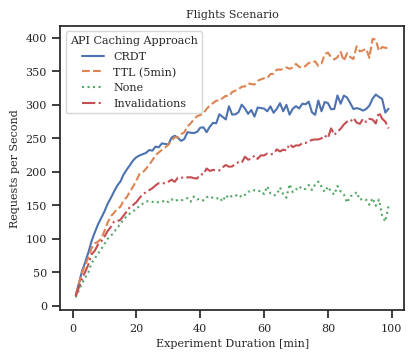

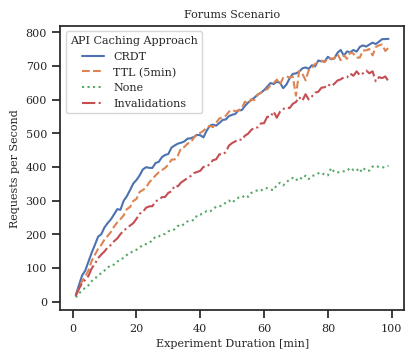

In [13]:
for plot_me in [('flights', requests_per_client_flights_pdf), ('forums', requests_per_client_forums_pdf)]:
    plot_flights_forum_plots_advanced([plot_me], reverse_plotting=False,
        plot_pdf = lambda pdf, ax, first: pdf.plot(color=COLOR_PALETTE, style=LINE_STYLES, ax=ax, legend='auto' if first else None),
        name = 'request_per_client',
        ylabel='Requests per Second', xlabel='Experiment Duration', x_unit= 'min', legend_title='API Caching Approach'
)

In [14]:
# Interactive Version of Plots
for plot_me in [
    ('request_per_client_flights', '(a) Flight Scenario', requests_per_client_flights_pdf), 
    ('request_per_client_forums', '(b) Forum Scenario', requests_per_client_forums_pdf)
]:
    fig = px.line(plot_me[2].rename(columns={ 'CRDT': 'CRDT Web Caching'}))
    fig.update_layout(xaxis_title='Experiment Duration',
                       yaxis_title='Throughput [requests/s]', legend_title_text='API Caching Approach', hovermode="x unified",  title=plot_me[1],
                      paper_bgcolor='rgba(0,0,0,0)')
    fig.update_xaxes(ticksuffix=' min')
    fig.update_traces(hovertemplate=None)
    fig.write_html(plot_dir / f'{plot_me[0]}.html', full_html=False, include_plotlyjs='directory')
    # fig.show()

In [15]:
def get_read_latency_summary(scenario: Scenario):
    result_pdf = scenario.map_experiment_long(lambda exp: pd.DataFrame(exp.client_pdf()[['duration']].agg('mean'), columns=['mean_read_latency']))
    #result_pdf = pdf[['experiment', 'duration']].groupby('experiment').agg('mean').reset_index()
    result_pdf['scenario'] = scenario.name
    return result_pdf.set_index(['scenario', 'experiment'])
read_latencies_summary_pdf = pd.concat([get_read_latency_summary(flight_scenario), get_read_latency_summary(forum_scenario)])
read_latencies_summary_pdf

mean_read_latency
scenario experiment                      
flights  CRDT                   91.134738
         TTL (5min)             79.086224
         None                  334.945002
         Invalidations         106.772508
forums   CRDT                   94.664408
         TTL (5min)             84.986418
         None                  184.969377
         Invalidations         105.462133

In [16]:
def calculate_read_latency(exp: Experiment):
    return exp.client_pdf().groupby('active_clients')['duration'].median()

read_latency_per_client_flights_pdf = flight_scenario.map_experiment(calculate_read_latency)
read_latency_per_client_forums_pdf = forum_scenario.map_experiment(calculate_read_latency)

In [17]:
def calculate_write_latency(exp: Experiment):
    return exp.client_pdf(CLIENT_WRITE_SUCESS_MSG).groupby('active_clients')['duration'].median()

write_latency_per_client_flights_pdf = flight_scenario.map_experiment(calculate_write_latency)
write_latency_per_client_forums_pdf = forum_scenario.map_experiment(calculate_write_latency)

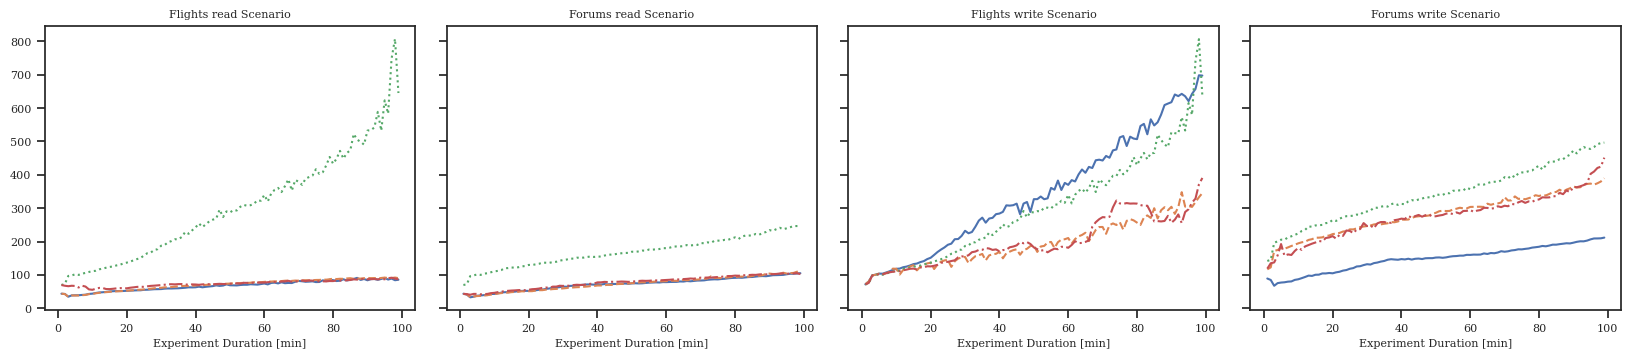

In [18]:
plot_me = [
    ('flights read', read_latency_per_client_flights_pdf), 
    ('forums read', read_latency_per_client_forums_pdf), 
    ('flights write', write_latency_per_client_flights_pdf), 
    ('forums write', write_latency_per_client_forums_pdf)]
plot_flights_forum_plots_advanced(plot_me, reverse_plotting=False,
     plot_pdf = lambda pdf, ax, first: pdf.plot(color=COLOR_PALETTE, style=LINE_STYLES, ax=ax, legend='auto' if first else None),
     name = 'latency_per_client',
     ylabel='Median Latency', xlabel='Experiment Duration', y_unit= 'ms', x_unit='min', legend_title='API Caching Approach', no_legend=True
)

In [19]:
# Interactive Version of Plots
for plot_me in [
    ('latency_per_client_flights_read', '(a) Read Requests - Flight Scenario', read_latency_per_client_flights_pdf), 
    ('latency_per_client_forums_read', '(b) Read Requests - Forum Scenario', read_latency_per_client_forums_pdf), 
    ('latency_per_client_flights_write', '(c) Write Requests - Flight Scenario', write_latency_per_client_flights_pdf), 
    ('latency_per_client_forums_write', '(d) Write Requests - Forum Scenario', write_latency_per_client_forums_pdf)]:
    fig = px.line(plot_me[2].rename(columns={ 'CRDT': 'CRDT Web Caching'}))
    fig.update_layout(xaxis_title='Experiment Duration',
    yaxis_title = 'Median Latency', legend_title_text = 'API Caching Approach', hovermode = "x unified", title=plot_me[1],
    paper_bgcolor = 'rgba(0,0,0,0)')
    fig.update_xaxes(ticksuffix=' min')
    fig.update_yaxes(ticksuffix=' ms')
    fig.update_traces(hovertemplate=None)
    fig.write_html(plot_dir / f'{plot_me[0]}.html', full_html=False, include_plotlyjs='directory')
    # fig.show()

In [20]:
def get_write_latency_summary(scenario: Scenario):
    result_pdf = scenario.map_experiment_long(lambda exp: pd.DataFrame(exp.client_pdf(CLIENT_WRITE_SUCESS_MSG)[['duration']].agg('mean'), columns=['mean_write_latency']))
    result_pdf['scenario'] = scenario.name
    return result_pdf.set_index(['scenario', 'experiment'])
write_latencies_summary_pdf = pd.concat([get_write_latency_summary(flight_scenario), get_write_latency_summary(forum_scenario)])
write_latencies_summary_pdf

mean_write_latency
scenario experiment                       
flights  CRDT                   403.502860
         TTL (5min)             212.775427
         None                   331.342301
         Invalidations          214.493777
forums   CRDT                   189.800109
         TTL (5min)             305.924864
         None                   370.840189
         Invalidations          326.099348

In [21]:
def calculate_inconsistency_window(exp: Experiment):
    origin_pdf = exp.origin_df()
    client_pdf = exp.client_pdf()
    origin_pdf = origin_pdf[origin_pdf['version'] > 0]
    origin_pdf['last_version'] = origin_pdf['version'] - 1
    
    client_pdf = client_pdf.set_index(['object', 'version'])
    client_pdf['time'] = client_pdf['time'] / 10**3
    
    joined_pdf = origin_pdf.join(client_pdf, on=['object', 'last_version'], lsuffix='_origin', rsuffix='_client', how='inner')[['active_clients_origin', 'object', 'version', 'time_origin', 'time_client']]\
        .groupby(['active_clients_origin', 'object', 'version', 'time_origin']).agg('max').reset_index()
    
    joined_pdf['inconsistency_window'] = (joined_pdf['time_client'] - joined_pdf['time_origin']) / 10**3
    
    joined_pdf.loc[joined_pdf['inconsistency_window'] < 0, 'inconsistency_window'] = 0
    return joined_pdf

In [22]:
inconsistency_windows_flights = [ (exp, calculate_inconsistency_window(exp)) for exp in flight_scenario.experiments]

In [23]:
inconsistency_windows_forums = [ (exp, calculate_inconsistency_window(exp)) for exp in forum_scenario.experiments]

In [24]:
def get_inconsistency_summary(inconsistency_windows, scenario: Scenario):
    results = []
    for exp, window_df in inconsistency_windows:
        r_pdf = pd.DataFrame(window_df[['inconsistency_window']].agg('mean'), columns=['mean_inconsistency_windows'])
        r_pdf['experiment'] = exp.name
        results.append(r_pdf)
    result_pdf = pd.concat(results)
    result_pdf['scenario'] = scenario.name
    return result_pdf.set_index(['scenario', 'experiment'])
inconsistency_summary_pdf = pd.concat([get_inconsistency_summary(inconsistency_windows_flights, flight_scenario), get_inconsistency_summary(inconsistency_windows_forums, forum_scenario)])
inconsistency_summary_pdf

mean_inconsistency_windows
scenario experiment                               
flights  CRDT                           700.993933
         TTL (5min)                  279166.692724
         None                             2.533221
         Invalidations                 1194.422942
forums   CRDT                          1948.594033
         TTL (5min)                  287586.321343
         None                             1.346570
         Invalidations                 3684.819896

In [25]:
def calculate_staleness_df(exp: Experiment):
    origin_pdf = exp.origin_df()
    client_pdf = exp.client_pdf()
    origin_pdf = origin_pdf[origin_pdf['version'] > 0]
    origin_pdf['next_version'] = origin_pdf['version'] - 1
    origin_pdf = origin_pdf.set_index(['object', 'next_version'])
    
    joined_pdf = client_pdf.join(origin_pdf, on=['object', 'version'], rsuffix='_origin', validate='many_to_one')
    joined_pdf['time'] = joined_pdf['time'] / 10**3
    
    joined_pdf['stale'] = joined_pdf['time'] > joined_pdf['time_origin']
    return joined_pdf[['active_clients', 'stale']]

def calculate_staleness_summary_df(scenario: Scenario):
    result_pdf = scenario.map_experiment_long(lambda exp: calculate_staleness_df(exp).groupby('active_clients').agg(['count', 'sum']))
    result_pdf = result_pdf.groupby('experiment').agg('sum').reset_index()
    result_pdf['scenario'] = scenario.name
    result_pdf['staleness_ratio'] = result_pdf[('stale', 'sum')] / result_pdf[('stale', 'count')]
    return result_pdf.set_index(['scenario', 'experiment'])['staleness_ratio']

In [26]:
staleness_summary_df = pd.concat(map(calculate_staleness_summary_df, [flight_scenario, forum_scenario]))
staleness_summary_df

scenario  experiment   
flights   CRDT             0.065375
          Invalidations    0.608033
          None             0.060372
          TTL (5min)       0.982942
forums    CRDT             0.260229
          Invalidations    0.168215
          None             0.005777
          TTL (5min)       0.493068
Name: staleness_ratio, dtype: float64

In [27]:
def calculate_cache_hit_ratio(exp: Experiment):
    client_success_pdf = exp.client_pdf()
    r_pdf = client_success_pdf[['active_clients', 'type', 'cached']].groupby('active_clients').agg(['count', 'sum'])
    r = r_pdf[('cached', 'sum')] / r_pdf[('type', 'count')]
    return r

cache_hit_ratio_per_client_flights_pdf = flight_scenario.map_experiment(calculate_cache_hit_ratio)
cache_hit_ratio_per_client_forums_pdf = forum_scenario.map_experiment(calculate_cache_hit_ratio)

In [28]:
def calculate_cache_hit_ratio_summary(scenario: Scenario):
    my_pdf = scenario.map_experiment_long(lambda exp: exp.client_pdf()[['active_clients', 'type', 'cached']].groupby('active_clients').agg(['count', 'sum']))
    result_pdf = my_pdf.groupby('experiment').agg('sum').reset_index()
    
    result_pdf['scenario'] = scenario.name
    result_pdf['cache_hit_ratio'] = result_pdf[('cached', 'sum')] / result_pdf[('type', 'count')]
    return result_pdf[['scenario', 'experiment', 'cache_hit_ratio']].set_index(['scenario', 'experiment'])['cache_hit_ratio']
cache_hit_ratio_summary_pdf = pd.concat(map(calculate_cache_hit_ratio_summary, [flight_scenario, forum_scenario]))
cache_hit_ratio_summary_pdf

scenario  experiment   
flights   CRDT             0.975134
          Invalidations    0.795493
          None             0.000000
          TTL (5min)       0.993223
forums    CRDT             0.999823
          Invalidations    0.812426
          None             0.000000
          TTL (5min)       0.995976
Name: cache_hit_ratio, dtype: float64

In [29]:
# Summary Table
# total requests, mean read, mean write, mean inconsistency window, staleness ratio, cache hit ratio, 
summary_table = pd.concat([total_requests_summary, read_latencies_summary_pdf, write_latencies_summary_pdf, inconsistency_summary_pdf, staleness_summary_df, cache_hit_ratio_summary_pdf], axis=1)
summary_table['total_requests_per_second'] = summary_table['total_requests_per_second'].apply(lambda x: f'{x:.1f}')
for ratio_column in ['staleness_ratio', 'cache_hit_ratio']:
    summary_table[ratio_column] = summary_table[ratio_column].apply(lambda x: f'{x:.1%}')
for float_column in ['mean_read_latency', 'mean_write_latency', 'mean_inconsistency_windows']:
    summary_table[float_column] = summary_table[float_column].apply(lambda x: f'{x / (1000 * 60):.1f}min' if x > 10000 else f'{x:.1f}ms')
summary_table

total_requests_per_second mean_read_latency  \
scenario experiment                                                  
flights  CRDT                              252.3            91.1ms   
         TTL (5min)                        281.1            79.1ms   
         None                              148.6           334.9ms   
         Invalidations                     200.7           106.8ms   
forums   CRDT                              527.3            94.7ms   
         TTL (5min)                        512.1            85.0ms   
         None                              270.0           185.0ms   
         Invalidations                     437.7           105.5ms   

                       mean_write_latency mean_inconsistency_windows  \
scenario experiment                                                    
flights  CRDT                     403.5ms                    701.0ms   
         TTL (5min)               212.8ms                     4.7min   
         None                     331.3ms                      2.5ms   
         Invalidations            214.5ms                   1194.4ms   
forums   CRDT                     189.8ms                   1948.6ms   
         TTL (5min)               305.9ms                     4.8min   
         None                     370.8ms                      1.3ms   
         Invalidations            326.1ms                   3684.8ms   

                       staleness_ratio cache_hit_ratio  
scenario experiment                                     
flights  CRDT                     6.5%           97.5%  
         TTL (5min)              98.3%           99.3%  
         None                     6.0%            0.0%  
         Invalidations           60.8%           79.5%  
forums   CRDT                    26.0%          100.0%  
         TTL (5min)              49.3%           99.6%  
         None                     0.6%            0.0%  
         Invalidations           16.8%           81.2%

In [30]:
print(summary_table.to_latex().replace('_', ' ').replace('%', '\\%'))

\begin{tabular}{llllllll}
\toprule
 &  & total requests per second & mean read latency & mean write latency & mean inconsistency windows & staleness ratio & cache hit ratio \\
scenario & experiment &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{flights} & CRDT & 252.3 & 91.1ms & 403.5ms & 701.0ms & 6.5\% & 97.5\% \\
 & TTL (5min) & 281.1 & 79.1ms & 212.8ms & 4.7min & 98.3\% & 99.3\% \\
 & None & 148.6 & 334.9ms & 331.3ms & 2.5ms & 6.0\% & 0.0\% \\
 & Invalidations & 200.7 & 106.8ms & 214.5ms & 1194.4ms & 60.8\% & 79.5\% \\
\cline{1-8}
\multirow[t]{4}{*}{forums} & CRDT & 527.3 & 94.7ms & 189.8ms & 1948.6ms & 26.0\% & 100.0\% \\
 & TTL (5min) & 512.1 & 85.0ms & 305.9ms & 4.8min & 49.3\% & 99.6\% \\
 & None & 270.0 & 185.0ms & 370.8ms & 1.3ms & 0.6\% & 0.0\% \\
 & Invalidations & 437.7 & 105.5ms & 326.1ms & 3684.8ms & 16.8\% & 81.2\% \\
\cline{1-8}
\bottomrule
\end{tabular}

